In [161]:
# %%writefile Ind_CMO_TRE.py

import sys
import os 
module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path: 
    sys.path.append(module_path)

import Ind_Model_Base

import numpy as np
import pandas as pd

import QUANTAXIS as QA

import matplotlib.pyplot as plt


import Analysis_Funs as af

import talib
# import base.JuUnits as ju

# %load_ext autoreload
# %autoreload 2
# %aimport Analysis_Funs,Ind_Model_Base


class CMO(Ind_Model_Base.Ind_Model):
    """动量线（MOM）
        jcsc21年之前还行...
        原指标不行
    """
    optimum_param={'valid':False, 'main':'feature_CMO_CONTINUITY', 'desition_direct':1, 'freq':'d','neutralize':{'enable':False,'static_mv':False}}
    
    def __init__(self,data, frequence=QA.FREQUENCE.DAY):
        super().__init__(data, 'CMO', frequence)
        self.renko_objs={}
        
        ### 正式使用时由实例设置为true来加速
#         self.set_ignore_sub_ind(False)
        

    def on_set_params_default(self):
        return {'timeperiod':20}
    
        
    def on_indicator_structuring(self, data):
        return self.excute_for_multicode(data, self.kernel, **self.pramas)
    
    def on_desition_structuring(self, data, ind_data):
        """
        """
        def feature(item_df):
            direct = np.sign(item_df['CMO'] - item_df['ma10'])
#             return -1 * np.abs( af.timeline_event_continuity(direct.fillna(0)) )
            return af.timeline_event_continuity(direct.fillna(0))

        event_continuity = self.excute_for_multicode(self.ind_df,
                                         lambda x: pd.DataFrame(feature(x),
                                         index=x.index,
                                         columns=['feature_CMO_CONTINUITY']))
        self.ind_df = pd.concat([self.ind_df, event_continuity],axis=1)
        return event_continuity
        
    def kernel(self,dataframe, timeperiod):
        # CMO=((Su-Sd)*100)/(Su+Sd)
        # Su是今日收盘价与昨日收盘价（上涨日）差值加总。若当日下跌，则增加值为0；
        # Sd是今日收盘价与做日收盘价（下跌日）差值的绝对值加总。若当日上涨，则增加值为0。 
        
        CMO = talib.CMO(dataframe.close, timeperiod)
#         diff = dataframe.close.diff()
#         Su_ = pd.Series(np.where(np.sign(diff)>=0,diff,0),index=diff.index)
#         Sd_ = pd.Series(np.where(np.sign(diff)<0,np.abs(diff),0),index=diff.index)

#         Su = Su_.rolling(timeperiod).apply(sum)
#         Sd = Sd_.rolling(timeperiod).apply(sum)
#         CMO=((Su-Sd)*100)/(Su+Sd)
        CMO.name = 'CMO'
        
        df = pd.DataFrame(CMO,columns=['CMO'])
        df['ma5'] = df['CMO'].rolling(5).mean()
        df['ma10'] = df['CMO'].rolling(10).mean()
        return df

    def plot(self):
        if self.fast_mode:
            raise 'fast_mode is True,cant draw chart'
        
        


Wall time: 87 ms


,,CMO,ma5,ma10,feature_CMO_CONTINUITY
date,code,,,,
2019-05-22,000001,NaN,NaN,NaN,0
2019-05-23,000001,NaN,NaN,NaN,0
2019-05-24,000001,NaN,NaN,NaN,0
2019-05-27,000001,NaN,NaN,NaN,0
2019-05-28,000001,NaN,NaN,NaN,0
...,...,...,...,...,...
2021-06-08,000001,17.089420,13.531950,16.870016,1
2021-06-09,000001,18.629331,15.240335,15.789182,2
2021-06-10,000001,10.526098,15.738319,14.295350,-1


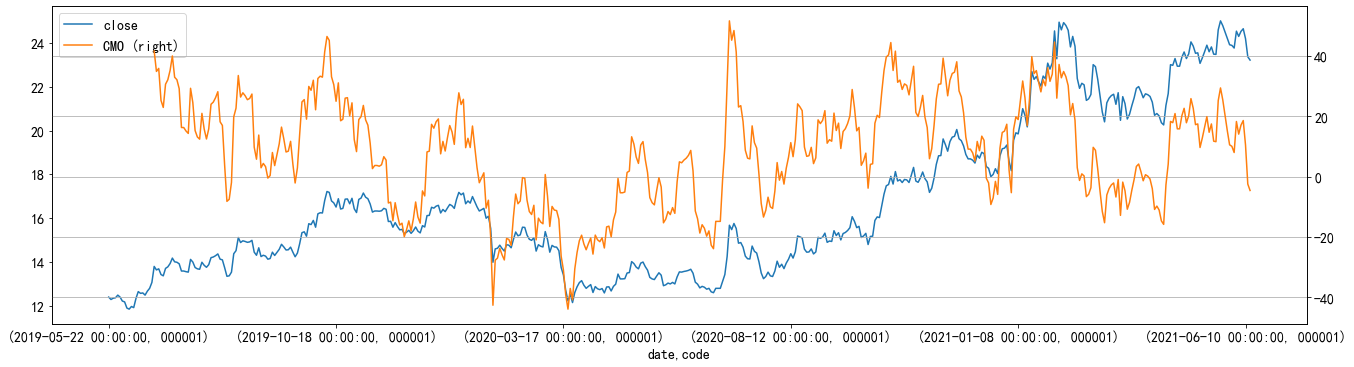

In [156]:
%%time
import sys
import os 
module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path: 
    sys.path.append(module_path)
import tools.Sample_Tools as smpl
import Analysis_Funs as af
import base.JuUnits as ju
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import talib
data = smpl.get_data(['000001'],end='2021-06-15',gap=504).data

cmo =CMO(data)
cmo.fit()
pd.concat([data.close,cmo.ind_df['CMO']],axis=1).plot(secondary_y=['CMO'],figsize=(1620/72,420/72))
plt.grid()
cmo.ind_df

# diff = data.close[0:10]
# np.where(np.sign(diff)>=0,diff,0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


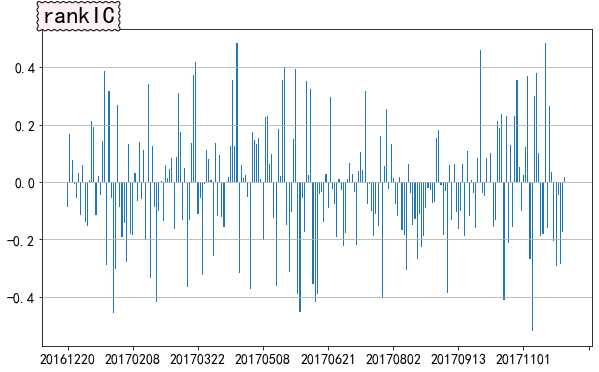

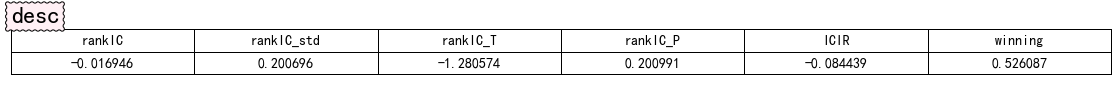

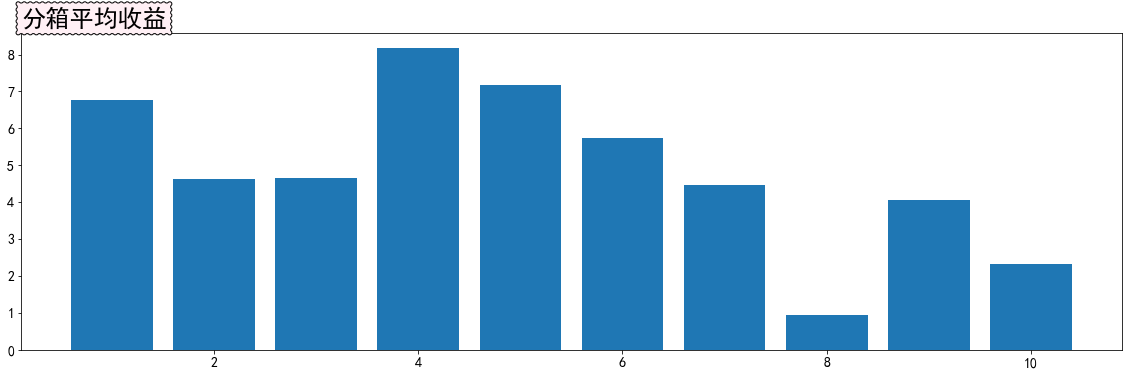

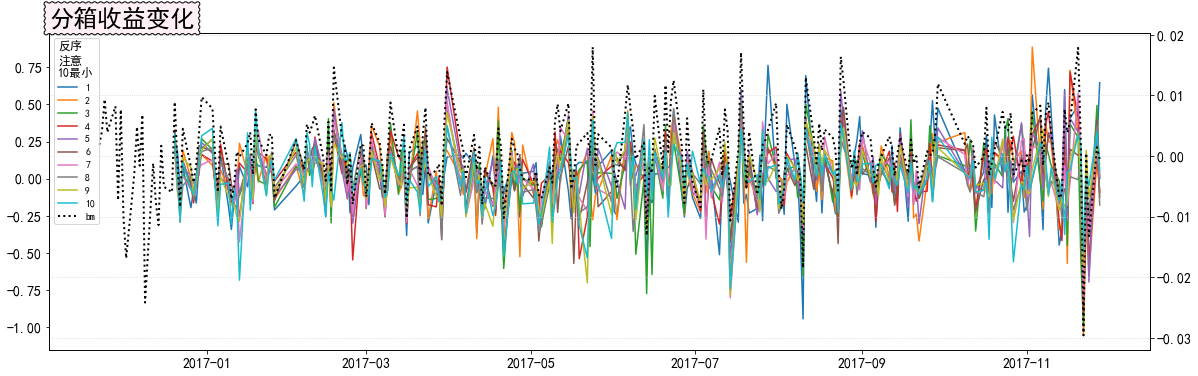

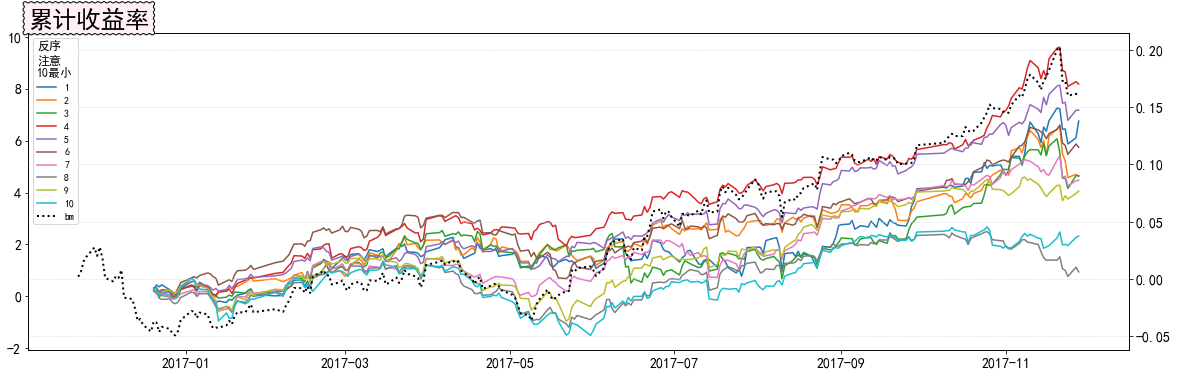

Wall time: 10.7 s


In [160]:
%%time
from tools.Test_Tools import FactorTest

%load_ext autoreload
%autoreload 1
%aimport tools.Test_Tools

test = FactorTest(CMO, sample='沪深300', freq="d",end='2017-11-29',gap=250,only_main=True,neutralize={'enable':False,'static_mv':False},target_field='CMO')
test.process()
test.plot()
